-- check the correlation between retweet counts & features <br>
-- OracleAnalytics generally retweets <br>
-- Need to check, why the Retweets are getting truncated <br>
 <br>
 <br>
-- Labeling the tweets as influential, where retweet counts are above threshold (10 for now) <br>
-- Identifying the most frequent words in influential tweets <br>
-- Checking the sentiments distribution for the influential tweets  <br>
-- checking the count of entities <br>
-- Measuring closeness centrality<br>


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re
import emoji
import spacy
from spacy import displacy
import en_core_web_sm
nlp = en_core_web_sm.load()
from collections import Counter


import warnings
warnings.filterwarnings('ignore')

In [110]:
data = pd.read_csv('oracleanalytics_tweets_1st.csv')
data.head()

,id,screen_name,created_at,retweeted,retweet_count,favorited,favorite_count,replyToSN,replyToUID,truncated,text,retweeted_status-user-screen_name,retweeted_status-user-description
0,1184750546571317248,gabbyr,2019-10-17 08:38:36,False,7,False,0,NaN,NaN,False,#OracleAnalytics Meetup ALERT! Wednesday: 10/3...,brunoaziza,Entrepreneur. Disrupter. Technologist. Forbes ...
1,1184741944645173248,AhmedSa68398426,2019-10-17 08:04:25,False,9,False,0,NaN,NaN,False,Check out Oracle Analytics Cloud version 105.4...,OracleAnalytics,Official account for Oracle Analytics and Orac...
2,1184741774423552000,AhmedSa68398426,2019-10-17 08:03:45,False,3,False,0,NaN,NaN,False,#Register now for an Oracle Analytics workshop...,OracleAnalytics,Official account for Oracle Analytics and Orac...
3,1184731610899451904,iamkirantailor,2019-10-17 07:23:21,False,15,False,0,NaN,NaN,False,#OracleAnalytics Desktop version 5.4 is now av...,philippe_lions,"Oracle #Analytics Product Manager, passionate ..."
4,1184710169000734723,Oracle_Barry,2019-10-17 05:58:09,False,3,False,0,NaN,NaN,False,#Register now for an Oracle Analytics workshop...,OracleAnalytics,Official account for Oracle Analytics and Orac...


<h3> Network Graphs </h3>

In [111]:
# Import networkx
import networkx as nx

# Create retweet network from edgelist
G_rt = nx.from_pandas_edgelist(
    data,
    source = 'screen_name',
    target = 'retweeted_status-user-screen_name',
    create_using = nx.DiGraph())
 
# Print the number of nodes
print('Nodes in RT network:', len(G_rt.nodes()))

# Print the number of edges
print('Edges in RT network:', len(G_rt.edges()))

Nodes in RT network: 97
Edges in RT network: 186


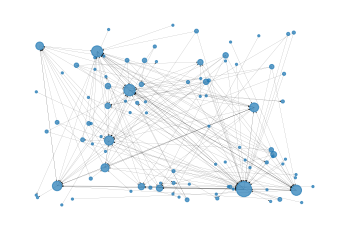

In [112]:
# Create random layout positions
pos = nx.random_layout(G_rt)


# Create size list
sizes = [x[1]*5 for x in G_rt.degree()]

# Draw the network
nx.draw_networkx(G_rt, pos, 
    with_labels = False, 
    node_size = sizes,
    width = 0.1, alpha = 0.7,
                 font_size = 5,
    arrowsize = 3, linewidths = 1)

# Turn axis off and show
plt.axis('off'); 
plt.show()

In [113]:
#Identifying the frequently retweeted users
data['retweeted_status-user-screen_name'].value_counts()

philippe_lions     59
OracleAnalytics    26
BenjaminArnulf     26
Oracle_Barry       23
gabbyr             18
Oracle_Doyle       14
brunoaziza         11
mmilella            8
NevianaZhgaba       7
Bec_Wagner          7
alan_w_lee          6
jvigeant            6
mylesgilsenan       5
PerfArchitects      4
daanalytics_nl      2
rittmanmead         2
ConnyBjorling       2
OracleBigData       2
DataVizMark         2
VerticeCloud        2
HEXstreamHQ         1
gtrauvit            1
duncanhf            1
usanalytics         1
bimobilelabs        1
CarrieVaiano        1
VerticalEdgeCG      1
prudence_IT         1
Name: retweeted_status-user-screen_name, dtype: int64

In [114]:
import string
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
import nltk
nltk.download('wordnet')

class CleanText(BaseEstimator, TransformerMixin):
   
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', input_text)
    
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        return input_text.replace('_','')
    
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)

    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)
    
    def to_lower(self, input_text):
        return input_text.lower()
    
    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words)   

    def lemmatizing(self, input_text):
        lemmatizer = WordNetLemmatizer() 
        words = input_text.split() 
        return " ".join([lemmatizer.lemmatize(word) for word in words])
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords).apply(self.lemmatizing)
        return clean_X

[nltk_data] Downloading package wordnet to C:\Users\Vertice
[nltk_data]     Guest\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [115]:
ct = CleanText()
data['clean_text'] = ct.fit_transform(data.text)

In [116]:
#creating class to convert text to features
class TextToFeatures:
    def __init__(self, df, textcol):
        self.df = df
        self.textcol = textcol
        self.c = 'spacy_'+ textcol
        self.df[self.c] = self.df[self.textcol].apply(lambda x: nlp(re.sub(r'http.?://[^\s]+[\s]?', '', x)))
        
        
        self.pos_tags = ['NOUN', 'VERB', 'ADP', 'ADJ', 'DET', 'PROPN', 'INTJ', 'PUNCT',\
                         'NUM', 'PRON', 'ADV', 'PART']
        self.dep_tags = ['amod', 'ROOT', 'punct', 'advmod', 'auxpass', 'nsubjpass',\
                         'ccomp', 'acomp', 'neg', 'nsubj', 'aux', 'agent', 'det', 'pobj',\
                         'prep', 'csubj', 'nummod', 'attr', 'acl', 'relcl', 'dobj', 'pcomp', \
                         'xcomp', 'cc', 'conj', 'mark', 'prt', 'compound', 'dep', 'advcl',\
                         'parataxis', 'poss', 'intj', 'appos', 'npadvmod', 'predet', 'case',\
                         'expl', 'oprd', 'dative', 'nmod']
        
      
    #def cleaning(self, words):
        
        #removing punctuation, stop words and lematizing
        #return ' '.join([word.lemma_ for word in words if word.is_punct == False & word.is_stop == False])
    
    def feature_extraction(self):
        
        #self.df['clean_text'] = self.df[self.c].apply(lambda x: self.cleaning(x)) 
        self.df['word_count'] = self.df[self.c].apply(lambda x:len([_ for _ in x]))
        self.df['word_count_clean'] = self.df['clean_text'].apply(lambda x: len(x.split()))
        self.df['char_count'] = self.df[self.textcol].apply(len)
        self.df['stopword_count'] = self.df[self.c].apply(lambda x: len([_ for _ in x if _.is_stop==True]))
        self.df['cap_word_counts'] = self.df[self.c].apply(lambda x: len([_ for _ in x if _.is_upper==True]))
        self.df['mentions_count'] = self.df[self.c].apply(lambda x: len([_ for _ in x if _.text[0]=='@']))
        self.df['hashtags_count'] = self.df[self.textcol].apply(lambda x: len(re.findall(r'#\w+', x)))
        self.df['count_excl_quest_marks'] = self.df[self.textcol].apply(lambda x: len(re.findall(r'!|\?', x)))
        self.df['count_urls'] = self.df[self.textcol].apply(lambda x: len(re.findall(r'http.?://[^\s]+[\s]?', x)))
        self.df['count_emojis'] = self.df[self.textcol].apply(lambda x: len(re.findall(r':[a-z_&]+:', emoji.demojize(x))))
        
        self.df['pos_tags'] = self.df[self.c].apply(lambda x: dict(Counter([ _.head.pos_ for _ in x])))
        self.df['dep_tags'] = self.df[self.c].apply(lambda x: dict(Counter([ _.head.dep_ for _ in x])))  
    
    def flatten_features(self):
        
        for key in self.pos_tags:
            self.df['_'+key] = self.df['pos_tags'].apply(lambda x: x[key] if key in x else 0)
        
        for key in self.dep_tags:
            self.df['_'+key] = self.df['dep_tags'].apply(lambda x: x[key] if key in x else 0)
    
    def generate_feaures(self):
        self.feature_extraction()
        self.flatten_features()
        self.df.drop(['pos_tags', 'dep_tags', self.c], axis=1, inplace=True)
        return self.df


                                                            
#wrapping above class into one funtion to generate features
def get_features(df, textcol):
    ft = TextToFeatures(df, textcol)
    return ft.generate_feaures()

In [117]:
df_eda = get_features(data, 'text')

In [118]:
data.fillna('', inplace = True)

<h3> Finding the frequent words</h3>

In [119]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_words(corpus, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    
    get_top_n_words(["I love Python", "Python is a language programming", "Hello world", "I love the world"]) -> 
    [('python', 2),
     ('world', 2),
     ('love', 2),
     ('hello', 1),
     ('is', 1),
     ('programming', 1),
     ('the', 1),
     ('language', 1)]
    """
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [120]:
#defining the threshold for influential retweets
data['influential'] = data['retweet_count'].apply(lambda x: 1 if x>10 else 0)

In [121]:
get_top_n_words(data[data.influential == 1].clean_text, n=100)

[('oracleanalytics', 45),
 ('oac', 35),
 ('feature', 34),
 ('desktop', 28),
 ('simple', 22),
 ('update', 20),
 ('go', 20),
 ('live', 20),
 ('deploy', 20),
 ('environment', 20),
 ('check', 20),
 ('new', 20),
 ('coming', 20),
 ('first', 20),
 ('list', 20),
 ('selected', 20),
 ('item', 20),
 ('stay', 20),
 ('tuned', 20),
 ('whole', 20),
 ('team', 20),
 ('example', 20),
 ('version', 14),
 ('available', 14),
 ('download', 14),
 ('oracle', 14),
 ('web', 14),
 ('site', 14),
 ('enjoy', 14),
 ('latest', 14),
 ('exciting', 14),
 ('based', 14),
 ('install', 14),
 ('everything', 11),
 ('copy', 11),
 ('paste', 11),
 ('amp', 2),
 ('ready', 1),
 ('analytics', 1),
 ('goodness', 1),
 ('join', 1),
 ('get', 1),
 ('exclusive', 1),
 ('oow', 1),
 ('announcement', 1),
 ('recap', 1),
 ('engage', 1),
 ('panel', 1),
 ('event', 1),
 ('sponsor', 1),
 ('part', 1),
 ('halloween', 1),
 ('datathon', 1)]

<h3> Evaluating the sentiment distribution</h3>

In [122]:
#evaluating the sentiment scores for reviews
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def sentiment_score(review):
    analyser = SentimentIntensityAnalyzer()
    return analyser.polarity_scores(review)

sentiment_results = [sentiment_score(row) for row in data['clean_text']]

data = data.join(pd.DataFrame(sentiment_results))
data.head()

,id,screen_name,created_at,retweeted,retweet_count,favorited,favorite_count,replyToSN,replyToUID,truncated,...,_case,_expl,_oprd,_dative,_nmod,influential,neg,neu,pos,compound
0,1184750546571317248,gabbyr,2019-10-17 08:38:36,False,7,False,0,,,False,...,0,0,0,0,0,0,0.0,0.821,0.179,0.3612
1,1184741944645173248,AhmedSa68398426,2019-10-17 08:04:25,False,9,False,0,,,False,...,0,0,0,0,0,0,0.0,1.000,0.000,0.0000
2,1184741774423552000,AhmedSa68398426,2019-10-17 08:03:45,False,3,False,0,,,False,...,0,0,0,0,0,0,0.0,0.625,0.375,0.7184
3,1184731610899451904,iamkirantailor,2019-10-17 07:23:21,False,15,False,0,,,False,...,0,0,0,0,0,1,0.0,0.686,0.314,0.7506
4,1184710169000734723,Oracle_Barry,2019-10-17 05:58:09,False,3,False,0,,,False,...,0,0,0,0,0,0,0.0,0.625,0.375,0.7184


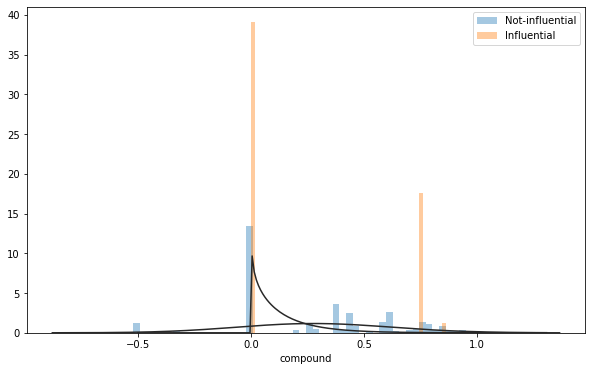

In [123]:
from scipy import stats

plt.figure(figsize = (10,6))
sns.distplot(data[data.influential == 0]['compound'], kde=False, bins = 50, fit=stats.gamma, label = 'Not-influential')
sns.distplot(data[data.influential == 1]['compound'], kde=False, bins = 50,  fit=stats.gamma, label = 'Influential')
plt.legend()

For the influential tweet, mostly the tweets are in neutral sentiment or close to 0.75

In [124]:
data[data.influential == 1]['compound'].describe()

count    46.000000
mean      0.247193
std       0.359651
min       0.000000
25%       0.000000
50%       0.000000
75%       0.750600
max       0.862500
Name: compound, dtype: float64

<h3> Viewing the correlation of other features with retweet count</h3>

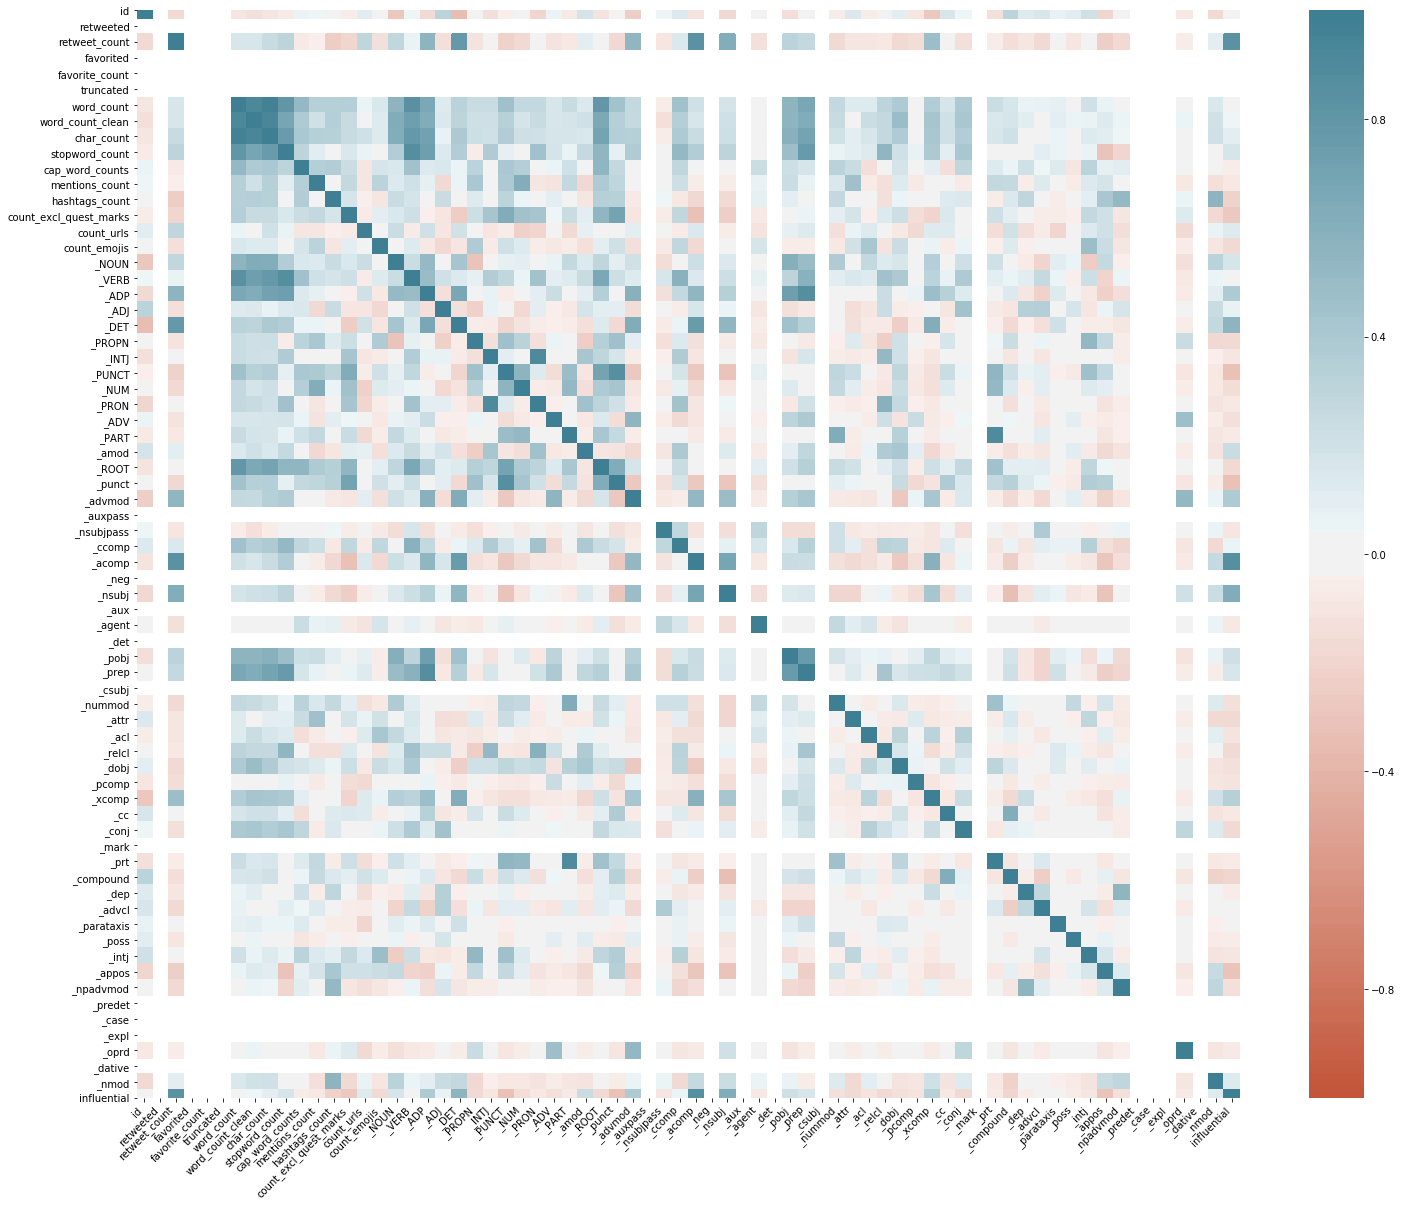

In [125]:
plt.figure(figsize=(25,20))
corr = df_eda.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

their are several features which have correlation with retweet count

In [126]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Classifiers = [
    LogisticRegression(C=0.000000001,solver='liblinear',max_iter=200),
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=200),
    AdaBoostClassifier(),
    GaussianNB()]

In [271]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data.drop(['id', 'screen_name', 'created_at', 'retweeted', 'retweet_count', 
                                           'favorited', 'favorite_count', 'replyToSN','replyToUID', 'truncated',
                                           'text'], axis =1) ,test_size=0.2,random_state=42)

from sklearn.feature_extraction.text import CountVectorizer
v = CountVectorizer(analyzer = "word", ngram_range=(2,3))
train_features= v.fit_transform(train.clean_text)
test_features=v.transform(test.clean_text)

dense_features=train_features.toarray()
dense_test= test_features.toarray()
Accuracy=[]
Model=[]
for classifier in Classifiers:
    try:
        fit = classifier.fit(train_features,train.influential)
        pred = classifier.predict(test_features)
    except Exception:
        fit = classifier.fit(dense_features,train.influential)
        pred = classifier.predict(dense_test)
    accuracy = accuracy_score(pred,test.influential)
    Accuracy.append(accuracy)
    Model.append(classifier.__class__.__name__)
    print('Accuracy of '+classifier.__class__.__name__+' is '+str(accuracy))


Accuracy of LogisticRegression is 0.9583333333333334
Accuracy of KNeighborsClassifier is 0.9791666666666666
Accuracy of SVC is 0.8125
Accuracy of DecisionTreeClassifier is 0.9791666666666666
Accuracy of RandomForestClassifier is 0.9791666666666666
Accuracy of AdaBoostClassifier is 0.9791666666666666
Accuracy of GaussianNB is 0.9583333333333334


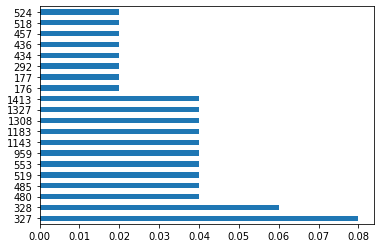

In [273]:
feat_importances = pd.Series(Classifiers[5].feature_importances_)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

In [274]:
for i in feat_importances.nlargest(20).index:
    print(list(v.vocabulary_)[list(v.vocabulary_.values()).index(i)])

copy paste
copy paste oracleanalytics
enjoy latest exciting
environment check new
everything simple copy
feature desktop based
new feature coming
oracleanalytics simple
paste oracleanalytics simple
selected item
site enjoy
team example
available download
available download oracle
coming first list
desktop based
desktop version
download oracle web
everything simple
exciting feature


In [275]:
test_word = "everything as simple as copy paste Join Vertice at Oracle’s Moorgate offices on 27th November to see how Oracle Autonomous Data Warehouse and Oracle Analytics Cloud can help you and your company detect fraud. #Oracle #MachineLearning #OracleAce #Data #AIDriven #Fraud #Autonoumous #Database"

sentiment_score(test_word)

{'neg': 0.08, 'neu': 0.818, 'pos': 0.103, 'compound': 0.0258}

In [276]:
ct_test = CleanText()
cln_test_word = ct_test.fit_transform(pd.Series(test_word))

v_test_word = v.transform(cln_test_word)

for classifier in Classifiers:
    try:
        print('Prediction of '+classifier.__class__.__name__+' is : '+str(classifier.predict(v_test_word)[0]))
    except Exception:
        print('Prediction of '+classifier.__class__.__name__+' is : '+str(classifier.predict(v_test_word.toarray())[0]))


Prediction of LogisticRegression is : 0
Prediction of KNeighborsClassifier is : 1
Prediction of SVC is : 0
Prediction of DecisionTreeClassifier is : 1
Prediction of RandomForestClassifier is : 0
Prediction of AdaBoostClassifier is : 1
Prediction of GaussianNB is : 1


In [215]:
cln_test_word[0]

'join dr abigail giles–haigh chief data science officer vertice oracle ace oracle’s moorgate office th november learn oracle autonomous data warehouse help business prevent fraud oracle machinelearning oracleace data aidriven fraud autonoumous database'

In [216]:
test.groupby(['influential']).count()

,retweeted_status-user-screen_name,retweeted_status-user-description,clean_text,word_count,word_count_clean,char_count,stopword_count,cap_word_counts,mentions_count,hashtags_count,...,_predet,_case,_expl,_oprd,_dative,_nmod,neg,neu,pos,compound
influential,,,,,,,,,,,,,,,,,,,,,
0,39,39,39,39,39,39,39,39,39,39,...,39,39,39,39,39,39,39,39,39,39
1,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9


In [103]:
train.shape

(384, 71)